# Adult-PMR3508
**Author: Lucas Hattori**

This notebook creates a kNN classifier model for the Adult dataset that predicts whether the income of a certain individual is higher than 50k annualy or not. To do so, it was provided both a train dataset as well as a test dataset that includes an id for each individual, 14 features and the income level (in the train dataset). This notebook is divided in the following sections:

#### Table of contents
1. [Imports](#imports)
2. [Exploratory Data Analysis](#eda)
    1. [Data dimensions](#dim)
    2. [Target variable](#target)
    3. [Data types](#dtype)
    4. [Categorical features](#cat)
    5. [Numerical features](#num)
3. [Modelling](#model)
    1. [Data prep](#prep)
    2. [Scalling](#scale)
    3. [Hyperparameter tuning](#hyper)
    4. [Metrics](#metric)
4. [Predicting](#predict)

## 1. Imports <a name="imports"></a>

This section contains both importing of libs utilized and reading the data provided.

In [1]:
## Libs utilized
import pandas as pd
import numpy as np
import missingno as msno

import scikitplot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import RobustScaler, StandardScaler, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay,roc_curve

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
## Data provided
df_train = pd.read_csv('./data/raw/train_data.csv', na_values='?')
df_test = pd.read_csv('./data/raw/test_data.csv', na_values='?')

In [3]:
## Preview of data
df_train.head()

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


## 2. Exploratory Data Analysis <a name="eda"></a>

This sections contains the EDA process.

### 2.1 Data dimensions <a name="dim"></a>

In [4]:
## Sample size provided
n_train_samples = df_train.shape[0]
n_test_samples = df_test.shape[0]
proportion = n_test_samples / n_train_samples
print(f'Number of training samples: {n_train_samples}')
print(f'Number of testing samples: {n_test_samples}. This represents {round(proportion,4)*100}% of the traning sample size.')
print('')
print(f'Number of rows in train dataset with missing values: {n_train_samples - df_train.dropna().shape[0]}.\
 That represents {round((1-df_train.dropna().shape[0]/n_train_samples)*100,2)}% of the total dataset.')
print(f'Number of rows in test dataset with missing values: {n_test_samples - df_test.dropna().shape[0]}.\
 That represents {round((1-df_test.dropna().shape[0]/n_test_samples)*100,2)}% of the total dataset.')

Number of training samples: 32560
Number of testing samples: 16280. This represents 50.0% of the traning sample size.

Number of rows in train dataset with missing values: 2399. That represents 7.37% of the total dataset.
Number of rows in test dataset with missing values: 1221. That represents 7.5% of the total dataset.


In [5]:
missing_data_train = df_train.isna().sum()
missing_data_test = df_test.isna().sum()
missing_data = pd.concat((missing_data_train,missing_data_test), axis=1)
missing_data.columns = ['Training', 'Testing']
missing_data = missing_data.loc[missing_data['Training']>0]
missing_data['% of train total'] = missing_data['Training'] * 100 / n_train_samples
missing_data['% of test total'] = missing_data['Testing'] * 100 / n_test_samples 
missing_data[['Training', '% of train total', 'Testing', '% of test total']]

,Training,% of train total,Testing,% of test total
workclass,1836,5.638821,963.0,5.915233
occupation,1843,5.660319,966.0,5.933661
native.country,583,1.790541,274.0,1.683047


Three features have missing data: _workclass_, _occupation_ and _native.country_. It's a significant amount (around 7%), both in the training dataset as well as in the testing. It'll be necessary to find methods to fill in these missing values. That process will be done in a specific manner for each feature, so that the best method is chosen for each feature.

### 2.2 Target variable - Income level <a name="target"></a>

Check the distribution of the target variable.

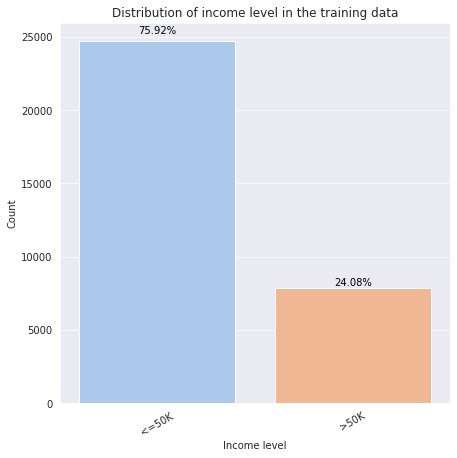

In [6]:
df2plot = df_train.groupby(['income'],as_index=False).agg({'Id':'count'})
df2plot.sort_values(by=['Id'], inplace=True, ascending=False)
f = plt.figure(figsize=(7,7))
with sns.axes_style("darkgrid"):
    ax = sns.barplot(x='income', y='Id', data=df2plot, palette='pastel')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{round(height/ df_train.shape[0] * 100,2)}%', (x + width/2, height*1.02), ha='center')

plt.title('Distribution of income level in the training data')
plt.xticks(rotation=30)
plt.ylabel('Count')
plt.xlabel('Income level')
plt.show()

### 2.3 Features data type <a name="dtype"></a>

In [7]:
pd.DataFrame(df_train.dtypes, columns=['dtype'])

,dtype
Id,int64
age,int64
workclass,object
fnlwgt,int64
education,object
education.num,int64
marital.status,object
occupation,object
relationship,object
race,object


As seen, of the 14 features, 8 are **categorical** while only 6 are **numerical.** Obviously, the _Id_ field is numerical and the _income_ is categorical (">50k"; "<=50k").

Let's look into each one of them:

### 2.4 Categorical features <a name="cat"></a>
The categorical features are: _workclass, education, marital.status, occupation, relationship, race, sex, native.country_.

In [8]:
#renaming for convenience
df_train.rename(columns={'marital.status':'marital_status', 'native.country':'native_country'},inplace=True)
df_test.rename(columns={'marital.status':'marital_status', 'native.country':'native_country'},inplace=True)

categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

In [9]:
num_nans = {}
num_classes = {}
for cat_feat in categorical_features:
    num_classes[cat_feat] = df_train[cat_feat].nunique()
    num_nans[cat_feat] = df_train[cat_feat].isna().sum()
pd.DataFrame(num_classes.items(),columns=['feature','num_classes']).set_index(['feature']).sort_values('num_classes',ascending=False)

,num_classes
feature,
native_country,41
education,16
occupation,14
workclass,8
marital_status,7
relationship,6
race,5
sex,2


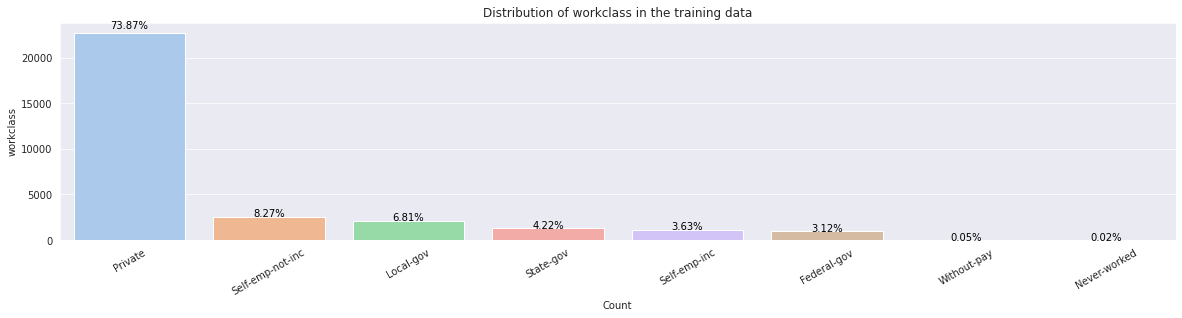

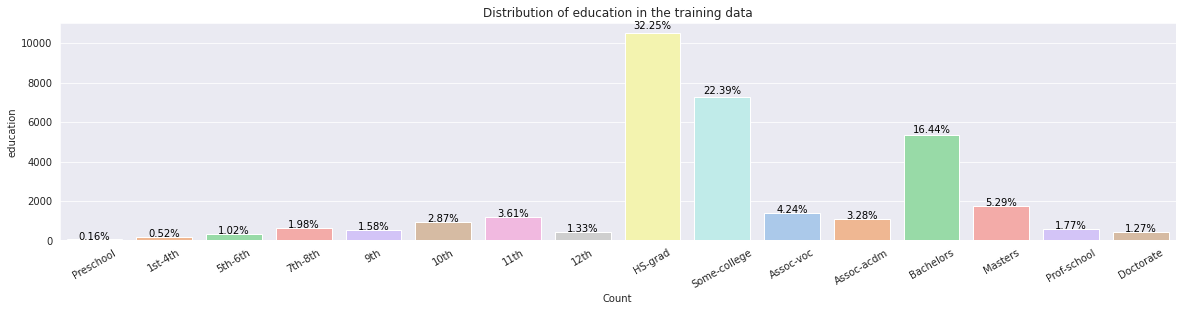

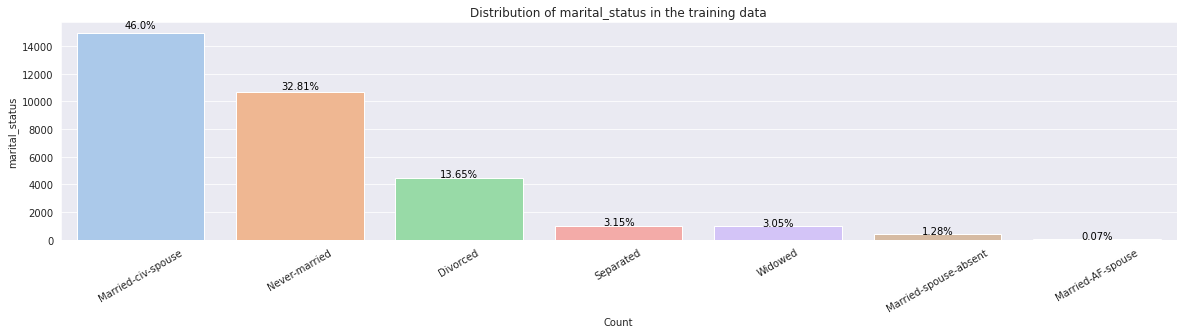

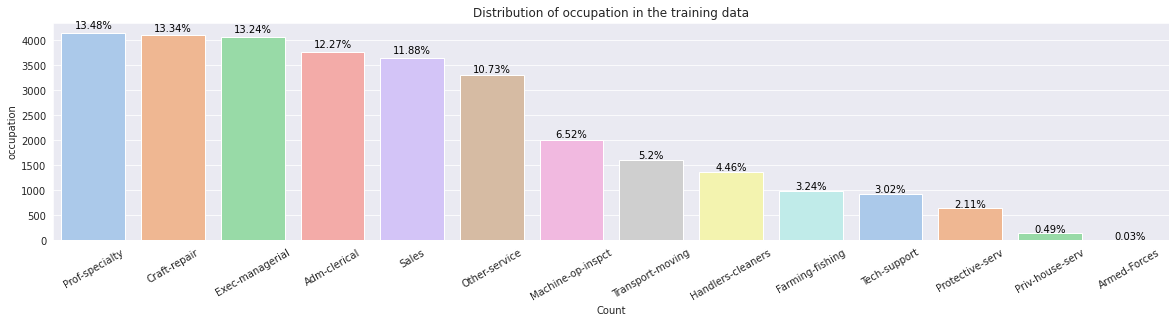

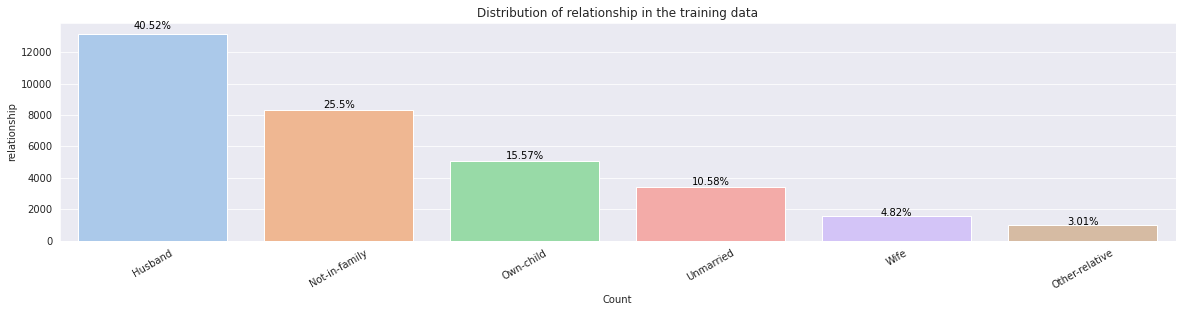

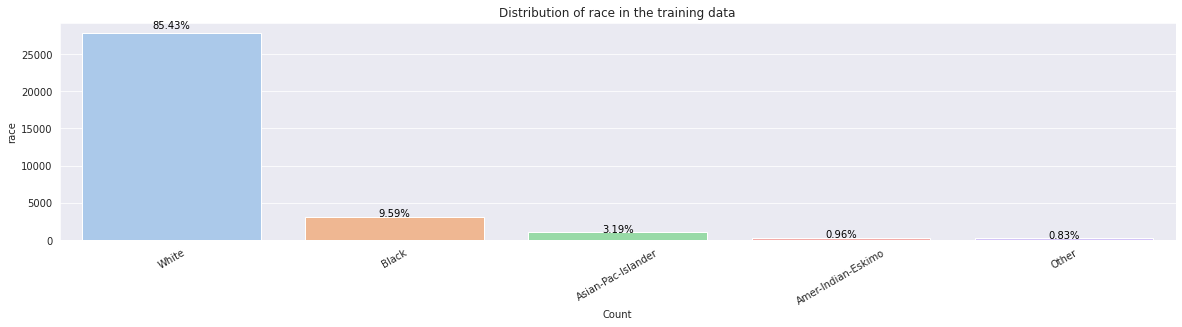

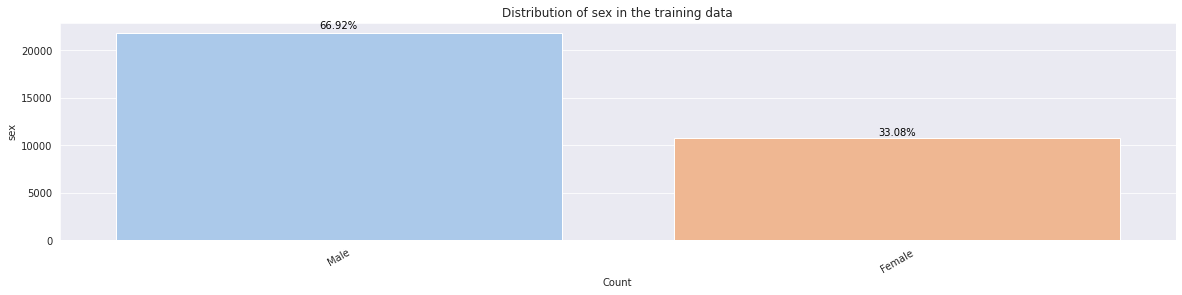

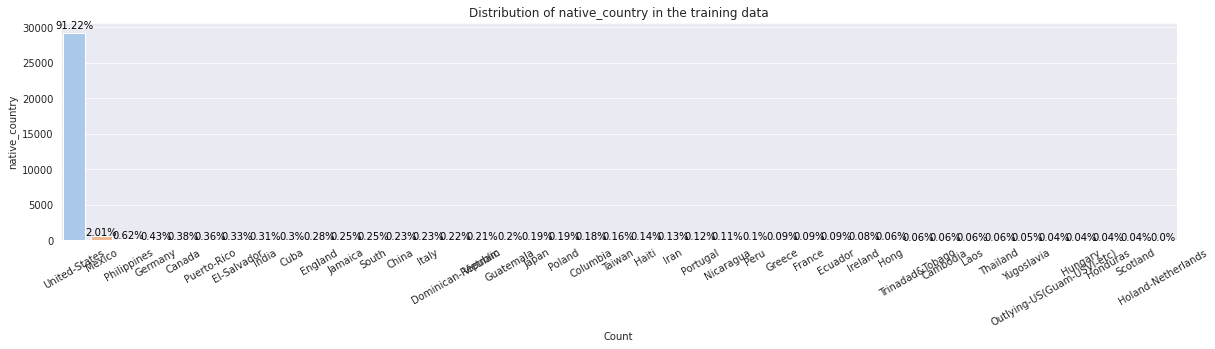

In [10]:
## Analysing the frequency for each class for each feature

for cat_feat in categorical_features:    
    if cat_feat == 'education':
        df2plot = df_train.groupby(['education','education.num'],as_index=False).agg({'Id':'count'})
        df2plot.sort_values(by='education.num', ascending=True, inplace=True)
    else:
        df2plot = df_train.groupby([cat_feat],as_index=False).agg({'Id':'count'})
        df2plot.sort_values(by=['Id'], inplace=True, ascending=False)
        

    f = plt.figure(figsize=(20,4))
    with sns.axes_style("darkgrid"):
        ax = sns.barplot(x=cat_feat, y='Id', data=df2plot, palette='pastel')

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{round(height/ (df_train.shape[0]-num_nans[cat_feat]) * 100,2)}%', (x + width/2, height*1.02), ha='center')

    plt.title(f'Distribution of {cat_feat} in the training data')
    plt.xticks(rotation=30)
    plt.xlabel('Count')
    plt.ylabel(cat_feat)
plt.show() 

Analysing the plots:
1. **Workclass**: is highly concentrated in one class "Private". Two of the classes are really rare, "Without-pay" and "Never-worked", and for the purpose of the classifier they're very similar, given that both of theses classes have no current income. 
2. **Education**: The most frequent classes are of "HS-grad" level or higher. Even still, summing all classes that are lower level than "HS-grad", we obtain almost 14% of the total population, which is a high percentage. It has a high cardinality.
3. **Marital_status**: Almost half of the sample is "Married-civ-spouse". Also not a high number of classes.
4. **Occupation**: Also has a high cardinality, i.e., high number of classes. It's not concentraded in any specific class.
5. **Relationship**: Low cardinality. The majority of the sample is "Husband".
6. **Race**: Low cardinality and highly concentrated in "White".
7. **Sex**: Only two classes. Aprox. 2/3 of the sample is "Male", which might induce the higher concentration in "Husband" in the **relantionship** feature.
8. **Native_country**: The highest cardinality. Also, extremely concentrated in one class, "United-States". The other 40 class are all below 1%, except for "Mexico". That indicates it might be necessary to reduce this dimensionality. The proposed method here is to create classes based on the continent of each country, resulting in the following classes: "United-States", "LATAM", "APAC", "Europe" and "Other". Besides, all the None values will be assigned as United-States, since its by far the most common class.

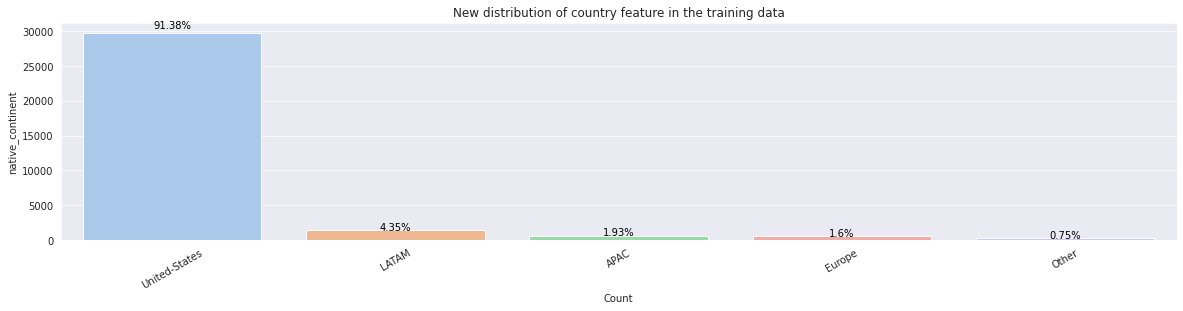

In [11]:
dict_countries = {
    'United-States':'United-States',
    # European
    'England':'Europe',
    'Greece':'Europe',
    'Germany':'Europe',
    'Italy':'Europe',
    'Poland':'Europe',
    'Portugal':'Europe',
    'Ireland':'Europe',
    'France':'Europe',
    'Hungary':'Europe',
    'Yugoslavia':'Europe',
    'Scotland':'Europe',
    'Holand-Netherlands':'Europe',
    # APAC - Asian Pacific
    'Cambodia':"APAC",
    'India':"APAC",
    'Hong':"APAC",
    'Japan':"APAC",
    'China':"APAC",
    'Philippines':"APAC",
    'Vietnam':"APAC",
    'Laos':"APAC",
    'Taiwan':"APAC",
    'Thailand':'APAC',
    # LATAM
    'Puerto-Rico':'LATAM',
    'Outlying-US(Guam-USVI-etc)':'LATAM',
    'Cuba':'LATAM',
    'Honduras':'LATAM',
    'Jamaica':'LATAM',
    'Mexico':'LATAM',
    'Dominican-Republic':'LATAM',
    'Ecuador':'LATAM',
    'Haiti':'LATAM',
    'Columbia':'LATAM',
    'Guatemala':'LATAM',
    'Nicaragua':'LATAM',
    'El-Salvador':'LATAM',
    'Trinadad&Tobago':'LATAM',
    'Peru':'LATAM',
    # Other
    'Canada':'Other',
    'South':'Other', # interpreted as South Africa
    'Iran':'Other'
}
df_train.loc[df_train['native_country'].isna(),'native_country'] = 'United-States'
df_train['native_continent'] = [dict_countries[country] for country in df_train['native_country']]
# Does the same for the test dataset
df_test.loc[df_test['native_country'].isna(),'native_country'] = 'United-States'
df_test['native_continent'] = [dict_countries[country] for country in df_test['native_country']]
# Replacing country for continent
categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_continent']

df2plot = df_train.groupby(['native_continent'],as_index=False).agg({'Id':'count'})
df2plot.sort_values(by=['Id'], inplace=True, ascending=False)


f = plt.figure(figsize=(20,4))
with sns.axes_style("darkgrid"):
    ax = sns.barplot(x='native_continent', y='Id', data=df2plot, palette='pastel')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{round(height/ (df_train.shape[0]) * 100,2)}%', (x + width/2, height*1.02), ha='center')

plt.title(f'New distribution of country feature in the training data')
plt.xticks(rotation=30)
plt.xlabel('Count')
plt.ylabel('native_continent')
plt.show()

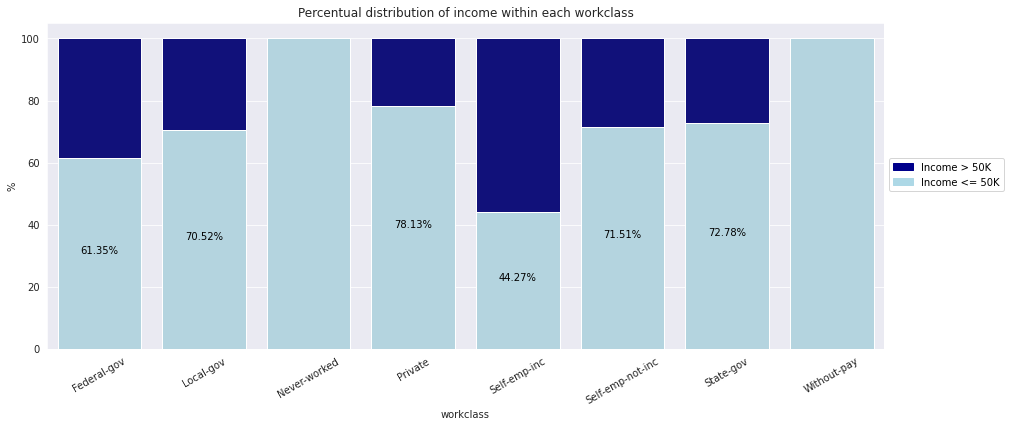

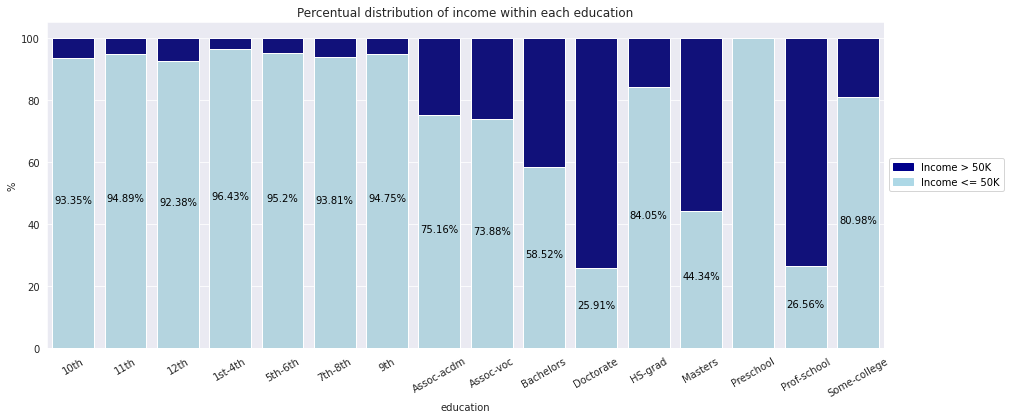

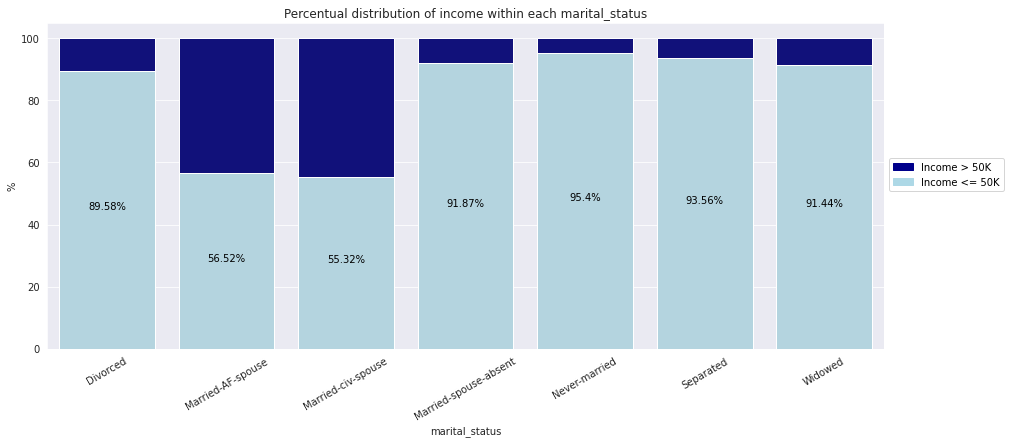

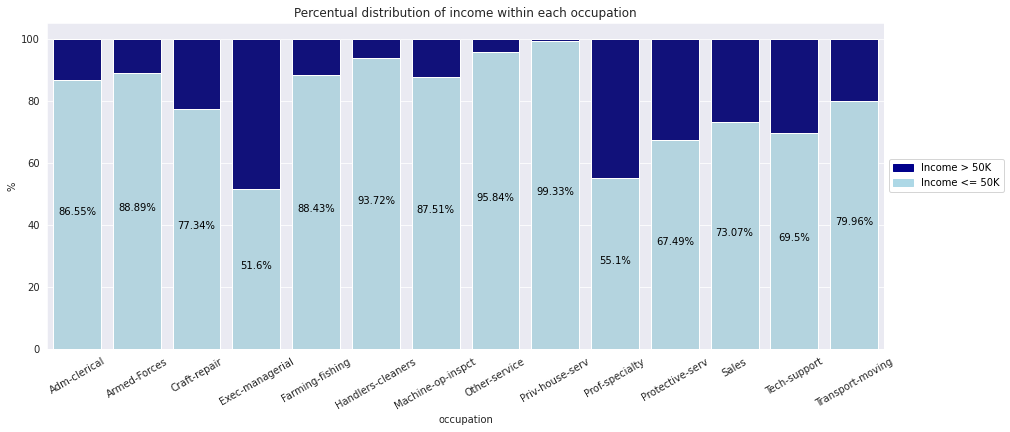

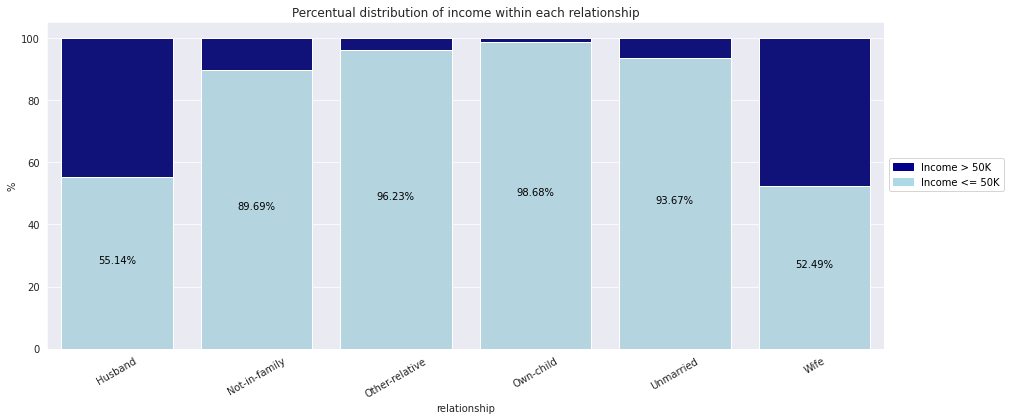

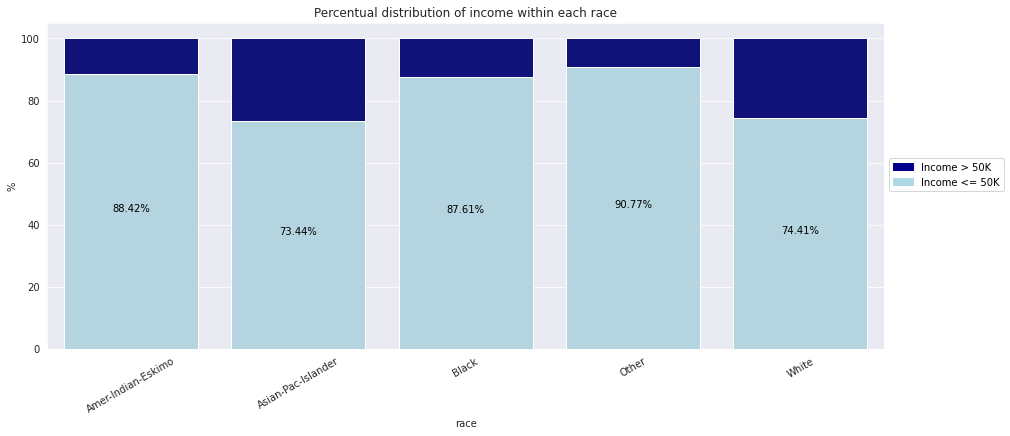

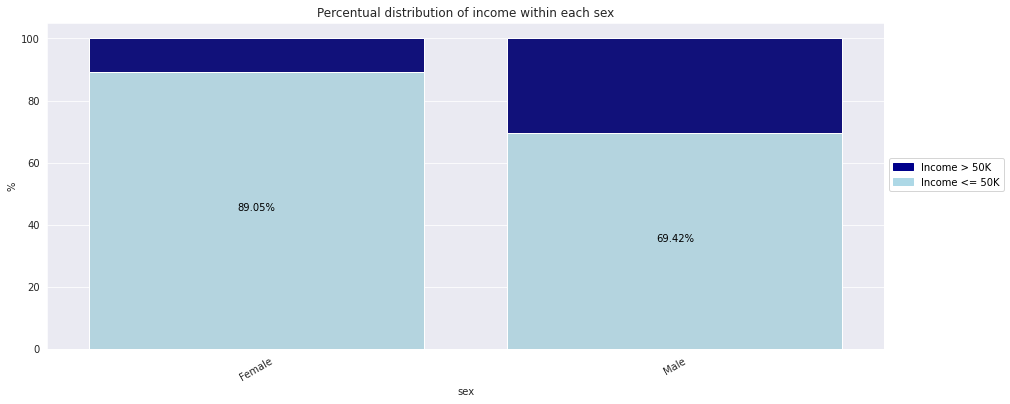

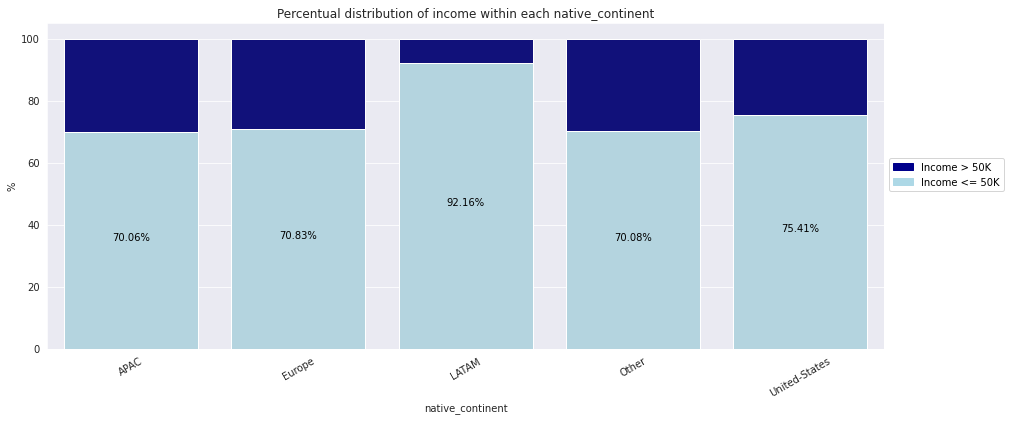

In [12]:
## Distribution of income level for each class in each feature

for cat_feat in categorical_features:    
    total = df_train.groupby([cat_feat],as_index=False).agg({'income':'count'})
    total.columns=[cat_feat, 'total']
    low_income = df_train.loc[df_train['income']=='<=50K'].groupby([cat_feat],as_index=False).agg({'income':'count'})
    low_income.columns=[cat_feat, 'less_than_50K']
    low_income = low_income.merge(total, on=cat_feat, how='left')
    low_income['pct_less_than_50K'] = low_income['less_than_50K'] / low_income['total'] * 100
    low_income['dummy'] = 100

    f = plt.figure(figsize=(15,6))
    with sns.axes_style("darkgrid"):
        # bar chart 1 -> top bars (group of 'smoker=No')
        bar1 = sns.barplot(x=cat_feat,  y='dummy', data=low_income, color='darkblue')

        # bar chart 2 -> bottom bars (group of 'smoker=Yes')
        bar2 = sns.barplot(x=cat_feat, y="pct_less_than_50K", data=low_income, color='lightblue')
    
    for p in bar2.patches:
        width = p.get_width()
        height = p.get_height()
        if height == 100:
            continue
        x, y = p.get_xy() 
        bar2.annotate(f'{round(height,2)}%', (x + width/2, height*0.5), ha='center')
    
    # add legend
    top_bar = mpatches.Patch(color='darkblue', label='Income > 50K')
    bottom_bar = mpatches.Patch(color='lightblue', label='Income <= 50K')
    plt.legend(handles=[top_bar, bottom_bar], bbox_to_anchor = (1.0, 0.6))
    plt.xticks(rotation=30)
    plt.ylabel('%')
    plt.title(f'Percentual distribution of income within each {cat_feat}')
    # show the graph
    plt.show()

All features seams to be important, since different classes have very different percentuals of each income level. Excepting **education**, all the other features will be encoded through One Hot Encoding, given that the number of classes is not too high for any of them.

Some specific points for each feature:
1. **Workclass**: As it seems to be a important feature it's important to fill the 1836 None values present in the original dataset, as they represent a significant amount of the total (approx. 5%). There are different ways to do so and setting all the None values as the most common class is the standard one. But, in this case, the most common class _Private_ has the second highest percentual for low income and setting all the missing values as _Private_ might induce undesirable bias in our model. Besides, there's no apparent reason for which individuals from this class would not have data, which might indicate that this is a case of Missing data At Random (MAR). So, my approach's going to be to **maintain the original distribution between classes**, as shown in the previous plot. Basically, for each sample with None value in workclass, I'll assign a random choice of class based on the original distribution.
2. **Education**: This feature apparently is important as well and is already encoded with no missing data.
3. **Marital_status**: The plots indicate that this is a relevant feature as well. As for the enconding, although there is a relationship between these classes, i.e., a _Divorced_ individual was once _Married_, it's not clear how this relationship between classes is quantifiable, so the encode wll be a simple One Hot. 
4. **Occupation**: Again, the distribution is not concentrated in a specific class and each class has very different proportions for each income level. I'll fill in the missing data using the same approach as in **workclass**.
5. **Relationship**: Apparently important, individuals that are married, i.e., "Husband" or "Wife" have higher incomes. Therefore, to reduce a sexist bias (given that already exists a feature for **Sex**), I'll treat them both as a new class "Married". That will also reduce the cardinality and favor a One Hot Encoding approach.
7. **Sex**: Although is a unbalanced dataset within this dimesion, the "Male" class has a higher income.
8. **Native_country**: This plot validates the approach used in the previous cell, as the income proportion for LATAM countries is much lower than other continents. In other hand, APAC, Europe and Other countries all have very similar proportions, around 70%.

In [13]:
## Creating new class for Relationship feature
df_train.loc[df_train['relationship'].isin(['Husband', 'Wife']), 'relationship'] = 'Married'
df_test.loc[df_test['relationship'].isin(['Husband', 'Wife']), 'relationship'] = 'Married'

In [14]:
## Filling data for Workclass and Occupation.
workclass_distribution = df_train['workclass'].value_counts(normalize=True)
df_train.loc[df_train['workclass'].isna(),'workclass'] = np.random.choice(workclass_distribution.index, size=df_train['workclass'].isna().sum(),p=workclass_distribution.values)
df_test.loc[df_test['workclass'].isna(),'workclass'] = np.random.choice(workclass_distribution.index, size=df_test['workclass'].isna().sum(),p=workclass_distribution.values)

occupation_distribution = df_train['occupation'].value_counts(normalize=True)
df_train.loc[df_train['occupation'].isna(),'occupation'] = np.random.choice(occupation_distribution.index, size=df_train['occupation'].isna().sum(),p=occupation_distribution.values)
df_test.loc[df_test['occupation'].isna(),'occupation'] = np.random.choice(occupation_distribution.index, size=df_test['occupation'].isna().sum(),p=occupation_distribution.values)

In [15]:
# Removing education because it's already encoded
categorical_features.remove('education')
df_train = pd.get_dummies(df_train, prefix=categorical_features, columns = categorical_features, drop_first=True)
df_test = pd.get_dummies(df_test, prefix=categorical_features, columns = categorical_features, drop_first=True)

### 2.5 Numerical features <a name="num"></a>
The categorical features are: _age, fnlwgt, capital.gain, capital.loss, hours.per.week._

As written in the document Extra-file-from-UCL.txt : _"Description of fnlwgt (final weight): The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. [...]People with similar demographic characteristics should have similar weights. **There is one important caveat to remember about this statement.  That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.**_

As said, this feature is only valid when applied for individuals from the same state. But in the dataset provided it's impossible to know which individuals are from which state, basically invalidating this feature. As the source of data itself states this condition, I'll not be using this feature for my classifier. 

In [16]:
#renaming for convenience
df_train.rename(columns={'capital.gain':'capital_gain', 'capital.loss':'capital_loss', 'hours.per.week':'hours_per_week'},inplace=True)
df_test.rename(columns={'capital.gain':'capital_gain', 'capital.loss':'capital_loss', 'hours.per.week':'hours_per_week'},inplace=True)

numerical_features = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']

**Feature engineering**
1. Create a flag for the individuals that have either gained or lost capital

In [17]:
df_train.loc[(df_train['capital_gain']!=0) | (df_train['capital_loss']!=0),'capital_moviment'] = 1
df_train['capital_moviment'].fillna(0,inplace=True)
df_test.loc[(df_test['capital_gain']!=0) | (df_test['capital_loss']!=0),'capital_moviment'] = 1
df_test['capital_moviment'].fillna(0,inplace=True)

In [18]:
df_num = df_train[numerical_features+['income']].copy()
# Creating a numerical column for the target variable
df_num.loc[df_num['income']=='>50K','income_level']=1
df_num.loc[df_num['income']=='<=50K','income_level']=0

In [19]:
df_num.describe()

,age,capital_gain,capital_loss,hours_per_week,income_level
count,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1077.615172,87.306511,40.437469,0.240817
std,13.640642,7385.402999,402.966116,12.347618,0.427586
min,17.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,99999.000000,4356.000000,99.000000,1.000000


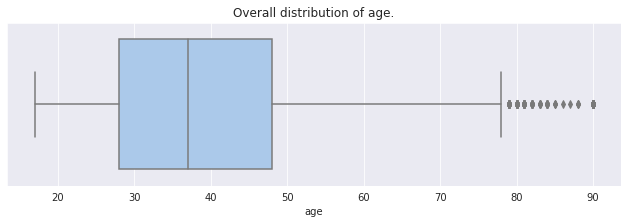

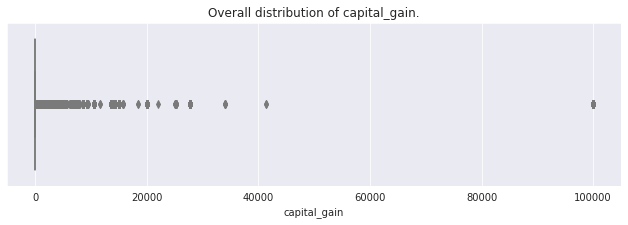

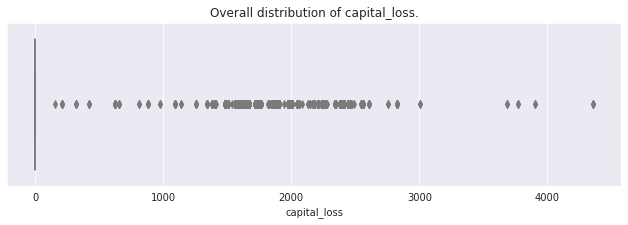

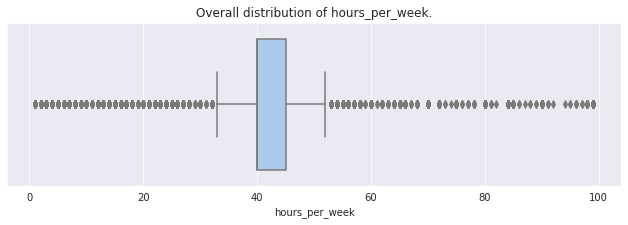

In [20]:
for num_feat in numerical_features:
    f = plt.figure(figsize=(11, 3))
    with sns.axes_style("darkgrid"):
        ax = sns.boxplot(x=num_feat, data=df_num, palette="pastel").set_title(f'Overall distribution of {num_feat}.')

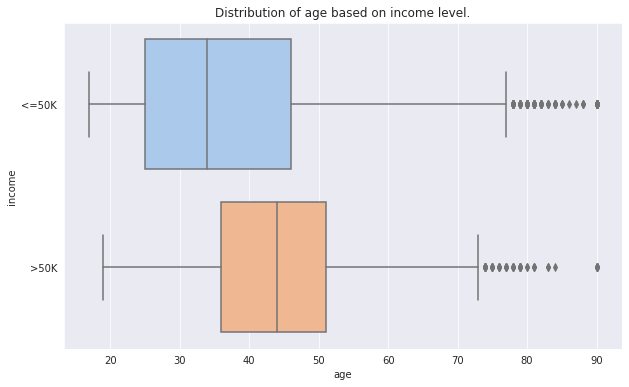

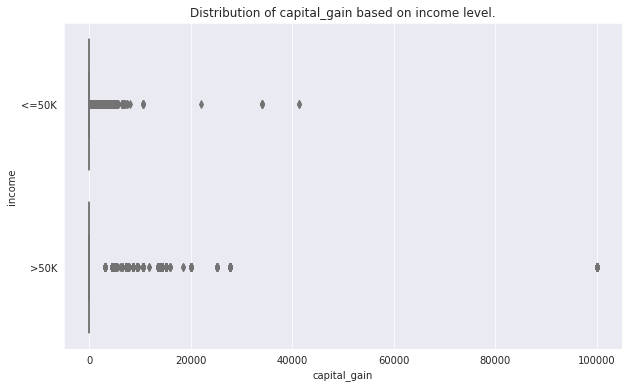

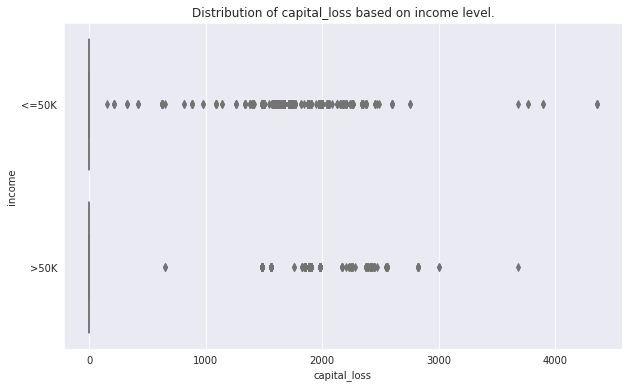

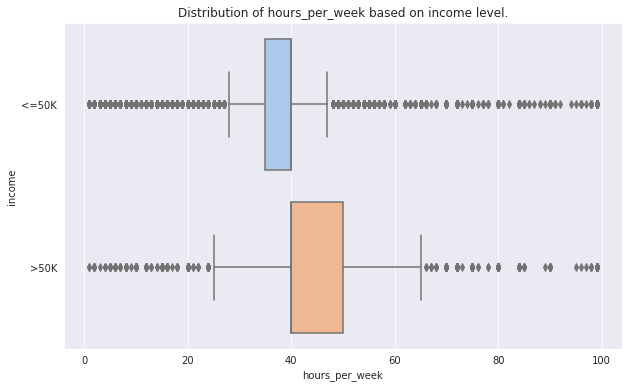

In [21]:
for num_feat in numerical_features:    
    f = plt.figure(figsize=(10,6))
    with sns.axes_style("darkgrid"):
        ax = sns.boxplot( x=num_feat, y="income", data=df_num, palette="pastel", orient='h').set_title(f'Distribution of {num_feat} based on income level.')

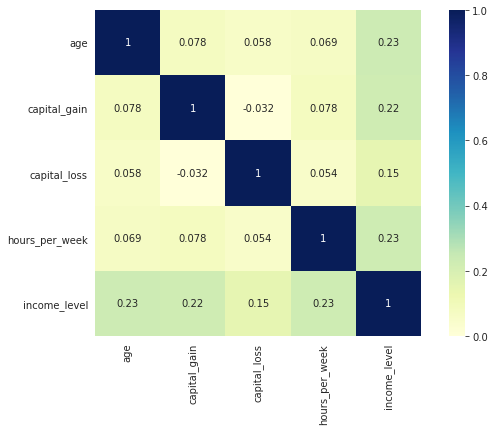

In [22]:
f = plt.figure(figsize=(10,6))
with sns.axes_style("darkgrid"):
    ax = sns.heatmap(df_num.corr(),square = True, annot=True, vmin=0, vmax=1,cmap="YlGnBu")

Analysing the plots, we can infer some facts:

1. **Age**: The sample size is concentrated in people between theirs late-20's and late-40's. There are some outliers older than 80 y.o. but none less than 17, which means that all individuals are legally able to work
2. **Capital_gain** and **capital_loss**: Over 75% of the individuals don't have neither losses nor gains. The **capital_gains** apparently are higher for people with high income, but the distribution for losses are not that different between income levels.
3. **Hours_per_week**: It has a high number of outliers as well, with the majority of individuals working around 40 hours per week. That's expected, since that's the standard journey legally in US.

## 3. Modelling <a name="model"></a>

### 3.1 Data prep <a name="prep"></a>

In [23]:
X = df_train.drop(columns=['Id','fnlwgt', 'education', 'native_country', 'income'])
X_test = df_test.drop(columns=['fnlwgt', 'education', 'native_country'])

y = df_train['income'].copy()

#split data into training and test dataset
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.20, random_state = 42)

### 3.2 Scalling <a name="scale"></a>

In [24]:
rs = RobustScaler()
columns = list(X_train.columns)
X_train[columns] = rs.fit_transform(X_train[columns].values)
X[columns] = rs.transform(X[columns].values)
X_val[columns] = rs.transform(X_val[columns].values)
X_test[columns] = rs.transform(X_test[columns].values)

### 3.3 Hyperparameter tuning <a name="hyper"></a>

In [25]:
# model definition
knn = KNeighborsClassifier()

# GridSearch CV
parameters = {'n_neighbors' : np.arange(5, 31, 5)}
knn_grid_cv = GridSearchCV(knn, parameters, verbose = True, cv = 5)
knn_grid_cv.fit(X_train, y_train)

print(f'Best estimator: {knn_grid_cv.best_estimator_}')
print(f'Best score: {knn_grid_cv.best_score_}')

y_pred = knn_grid_cv.predict(X_val)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best estimator: KNeighborsClassifier(n_neighbors=25)
Best score: 0.864250586519935


### 3.4 Metrics <a name="metric"></a>

In [26]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       <=50K       0.90      0.93      0.91      4974
        >50K       0.75      0.67      0.70      1538

    accuracy                           0.87      6512
   macro avg       0.82      0.80      0.81      6512
weighted avg       0.86      0.87      0.86      6512



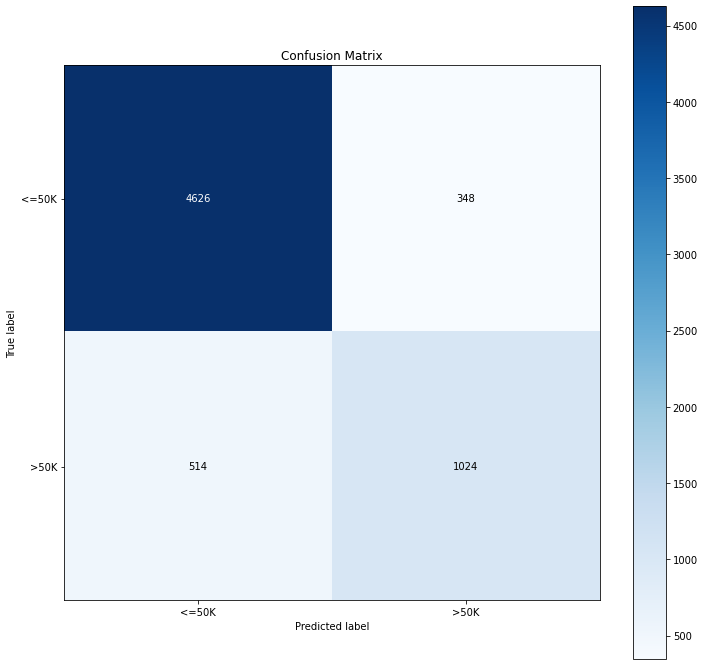

In [27]:
scikitplot.metrics.plot_confusion_matrix(y_val,y_pred, normalize = False, figsize = (12,12))
plt.show()

## 4 Predicting <a name="predict"></a>

In [28]:
# model definition
model = KNeighborsClassifier(n_neighbors=25)

# fitting model
model.fit(X, y)

KNeighborsClassifier(n_neighbors=25)

In [29]:
# predict
X_test['income'] = model.predict(X_test.drop(columns = 'Id'))

X_test.head()

,Id,age,education.num,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,race_Black,race_Other,race_White,sex_Male,native_continent_Europe,native_continent_LATAM,native_continent_Other,native_continent_United-States,capital_moviment,income
0,0,-0.60,1.000000,0.0,0.0,0.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<=50K
1,1,1.35,1.000000,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,>50K
2,2,-0.30,1.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,<=50K
3,3,0.40,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<=50K
4,4,1.35,1.000000,0.0,0.0,2.0,0.0,0.0,-1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,>50K


In [30]:
export_path = "./data/submissions/submission.csv"
X_test[['Id', 'income']].to_csv(export_path, index = False)